## Data analysis for touch tests
Stroke eyebrow hair across worm, then visually determine if the worm responded.
10 touches per worm
25 worms per cohort
1 plate per cohort
3 cohorts per dataset

### Import useful packages

In [1]:
import pandas as pd
from scipy import stats
from statsmodels.stats import multicomp 
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import time

start_time = time.time()

### Plot aesthetics

In [2]:
sns.set(font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')

### Load data from excel files

In [3]:
filenames = ['ATT_001_001.xlsx',
             'ATT_001_002.xlsx',
             'ATT_001_003.xlsx',
             'ATT_001_004.xlsx',
             'ATT_001_005.xlsx']
worm_strains = ['NM3573', 'GN885', 'GN886', 'GN887', 'GN906']
allele_dict = {'NM3573': 'control',
               'N2': 'wild-type',
               'GN885': 'him-4(e1267)',
               'GN886': 'mec-1(e1066)',
               'GN887': 'mec-1(e1738)',
               'GN906': 'mec-5(u444)'}
worm_strain_categories = pd.api.types.CategoricalDtype(categories=worm_strains, ordered=True)


base_folder = pathlib.Path('/Users/adam/Documents/SenseOfTouchResearch/TouchTests')

list_of_df_from_sheets = []
for data_file in filenames:
    data_file_path = base_folder.joinpath(data_file)
    all_sheets = pd.read_excel(data_file_path, sheet_name=None, header=0)
    for sheet in all_sheets.keys():
        current_metadata = all_sheets[sheet].iloc[27:29, 0:5]
        current_metadata.columns = current_metadata.iloc[0]
        current_metadata = current_metadata[1:]
        
        if not current_metadata.empty:  # filter out empty sheets
            this_sheet_df = all_sheets[sheet].iloc[0:25].melt(
                id_vars='Trials', value_vars=['Touch'+str(touch_num) for touch_num in range(1,11)])
            this_sheet_df['date'] = current_metadata['Date'].values[0]
            this_sheet_df['temperature'] = current_metadata['Temperat.'].values[0]
            this_sheet_df['humidity'] = current_metadata['Humidity'].values[0]
            this_sheet_df['strain_code'] = current_metadata['StrainCod'].values[0]
            this_sheet_df['strain_name'] = current_metadata['StrainDecod'].values[0]
            this_sheet_df['genotype'] = this_sheet_df['strain_name'].replace(allele_dict)
            this_sheet_df['variable'] = this_sheet_df['variable'].str.slice(start=5).astype('int')
            this_sheet_df.rename(columns={'Trials': 'worm_num',
                                          'variable': 'touch_num',
                                          'value': 'touch_outcome'}, inplace=True)
            list_of_df_from_sheets.append(this_sheet_df)

each_touch_result_df = pd.concat(list_of_df_from_sheets)
each_touch_result_df.fillna(0, downcast='infer', inplace=True)
each_touch_result_df['touch_outcome'] = each_touch_result_df['touch_outcome'].astype('int')

result_by_worm = each_touch_result_df.groupby(
    ['strain_name', 'genotype', 'strain_code', 'date', 'worm_num']).mean().reset_index().drop(
    axis='columns', labels='touch_num')
each_touch_result_df['strain_name'] = each_touch_result_df['strain_name'].astype(worm_strain_categories)
result_by_worm['strain_name'] = result_by_worm['strain_name'].astype(worm_strain_categories)

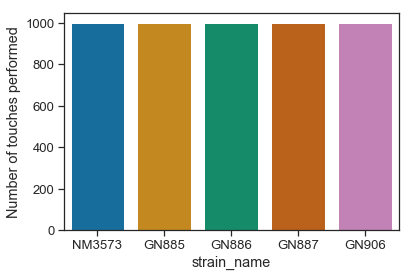

In [4]:
ax = sns.countplot(x='strain_name', data=each_touch_result_df)
ax.set_ylabel('Number of touches performed');

### Plot touch test results

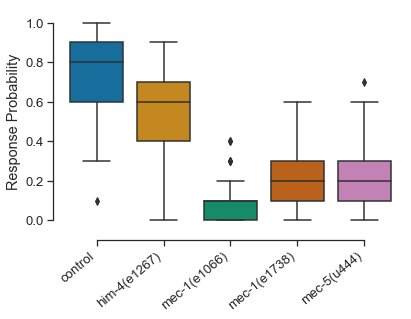

In [5]:
ax = sns.boxplot(x='strain_name', y='touch_outcome',
             data=result_by_worm)
ax.set_ylabel('Response Probability')
# labels = ax.get_xticklabels()
labels = [allele_dict[strain_name.get_text()] for strain_name in ax.get_xticklabels()]
sns.despine(offset=10, trim=True)
ax.set_xticklabels(labels, rotation=40, ha='right')
ax.set_xlabel('');

In [6]:
result_by_worm.groupby('strain_name').mean()['touch_outcome']

strain_name
NM3573    0.742
GN885     0.527
GN886     0.083
GN887     0.237
GN906     0.208
Name: touch_outcome, dtype: float64

### Statistical tests

In [7]:
touch_test_data = []
for this_worm_strain in worm_strains:
    touch_test_data.append(result_by_worm.loc[
        result_by_worm['strain_name'] == this_worm_strain]['touch_outcome'])
print(stats.f_oneway(*touch_test_data))

mc = multicomp.MultiComparison(result_by_worm['touch_outcome'], result_by_worm['genotype'],
                               group_order=[allele_dict[strain] for strain in worm_strains])
mc_results = mc.tukeyhsd()
print(mc_results)


F_onewayResult(statistic=268.11481787147807, pvalue=2.1628578236566302e-122)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     control him-4(e1267)   -0.215  0.001 -0.2785 -0.1515   True
     control mec-1(e1066)   -0.659  0.001 -0.7225 -0.5955   True
     control mec-1(e1738)   -0.505  0.001 -0.5685 -0.4415   True
     control  mec-5(u444)   -0.534  0.001 -0.5975 -0.4705   True
him-4(e1267) mec-1(e1066)   -0.444  0.001 -0.5075 -0.3805   True
him-4(e1267) mec-1(e1738)    -0.29  0.001 -0.3535 -0.2265   True
him-4(e1267)  mec-5(u444)   -0.319  0.001 -0.3825 -0.2555   True
mec-1(e1066) mec-1(e1738)    0.154  0.001  0.0905  0.2175   True
mec-1(e1066)  mec-5(u444)    0.125  0.001  0.0615  0.1885   True
mec-1(e1738)  mec-5(u444)   -0.029 0.6963 -0.0925  0.0345  False
----------------------------------------------------------------


In [9]:
print('Notebook ran in', str(round(time.time()-start_time)), 'seconds.')

Notebook ran in 4 seconds.
